In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pdp   # pip install pandas-profiling
import seaborn as sns
import time
from matplotlib import pyplot as plt
%matplotlib inline

# traps = pd.read_csv('assets/train.csv')
# spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')

# Preliminary EDA

In [2]:
# pdp.ProfileReport(traps)
# pdp.ProfileReport(spray)
# pdp.ProfileReport(weather)

# sns.pairplot(traps)
# sns.pairplot(spray)
# sns.pairplot(weather)

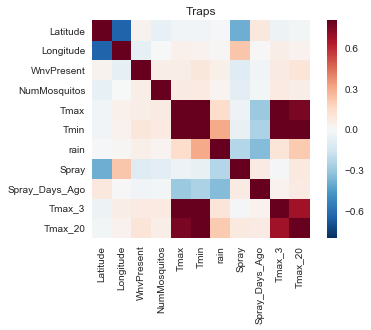

In [4]:
# def find_correlation(data,title):
#     correlation = data.corr()
#     sns.heatmap(correlation, vmax=.8, square=True)
#     plt.title(title)

# find_correlation(traps, 'Traps')

# Data Transformation

## Modify columns

In [25]:
# import datetime
# # Convert Date columns to actual date data type
traps.Date = pd.to_datetime(traps.Date)
# spray.Date = pd.to_datetime(spray.Date)
# weather.Date = pd.to_datetime(weather.Date)

# # Create dummies for Species
# dummies = pd.get_dummies(traps, columns=['Species'])

# # Create a new df with the dummies
# traps_2_cols = traps.columns.drop('Species')
# traps_2 = pd.concat([traps[traps_2_cols],dummies])

# Weather data:
# the PrecipTotal column contains the letter 'T' in some rows
# this indicates a 'trace' amount of precipitation, which is
# defined as less than 0.005
# 'M' indicates missing data
# 'PrecipTotal','Tavg'

# def clean_col(column):
#     weather[column] = weather[column].str.replace('T','0.005')
#     weather[column] = weather[column].str.replace('M','0.0')
#     weather[column] = weather[column].astype(float)


# clean_col('Tavg')
# clean_col('PrecipTotal')
# clean_col('WetBulb')
# clean_col('StnPressure')
# clean_col('SeaLevel')
# clean_col('AvgSpeed')

# weather.CodeSum = weather.CodeSum.str.strip()
# weather.CodeSum[weather.CodeSum.str.contains('^\w')] = '1'
# weather.CodeSum[weather.CodeSum!='1'] = '0'
# weather['Tavg'][weather.Tavg==0] = (weather.Tmin + weather.Tmax) / 2


## Grouping records from same trap, same day inspection

In [35]:
# # Because records are capped at 50 mosquitos,
# # we are grouping the data to obtain a unique
# # observation record per trap per date, with
# # a total sum of NumMosquitos

# traps = traps[['Trap',
#                'Latitude',
#                'Longitude',
#                'Date',
#                'Species',
#                'WnvPresent',
#                'NumMosquitos']].groupby(['Trap',
#                                          'Latitude',
#                                          'Longitude',
#                                          'Date', 
#                                          'Species',
#                                          'WnvPresent']).agg({'NumMosquitos':np.sum}).reset_index()

## Applying the weather data to the dataframe

In [9]:
## This function takes three arguments:
## The column name as a string from weather dataframe that we want to extract
## a numpy function that we want to do to the data
## an integer number of previous days to extraxct

def weather_add(df, weather_col, func, days_range=7):
    new_list = []
    for i in df['Date']:
        mask = (weather['Date'] <= i) & (weather['Date'] >= i - pd.Timedelta(days=days_range))
        data_list = func(weather[weather_col][mask])
        new_list.append(data_list)
    return new_list

In [26]:
## running this cell will extract the average temp min, average temp max, and precipitation sum 
## to the traps dataframe from the previous 7 days.

traps['Tmax'] = weather_add(traps, weather_col='Tmax', func=np.mean)
traps['Tmin'] = weather_add(traps, weather_col='Tmin', func=np.mean)
traps['rain'] = weather_add(traps, weather_col='PrecipTotal', func= np.sum)
traps['Tmax_3'] = weather_add(traps, weather_col='Tmax', func=np.mean, days_range=3)
traps['Tmax_20'] = weather_add(traps, weather_col='Tmax',func=np.mean, days_range=20)

for col in ['Tavg','DewPoint','WetBulb','CodeSum','StnPressure','SeaLevel', 'ResultSpeed', 'ResultDir','AvgSpeed']:
    traps[col] = weather_add(traps, weather_col=col, func=np.mean)


## Scale the Data 

In [27]:
traps[traps.rain.isnull()]

# Index([u'Trap', u'Latitude', u'Longitude', u'Date', u'Species', u'WnvPresent',
#        u'NumMosquitos', u'Tmax', u'Tmin', u'rain', u'Spray', u'Spray_Days_Ago',
#        u'Tmax_3', u'Tmax_20', u'Tavg', u'DewPoint', u'WetBulb', u'CodeSum',
#        u'StnPressure', u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed'],
# #       dtype='object')


,Trap,Latitude,Longitude,Date,Species,WnvPresent,NumMosquitos,Tmax,Tmin,rain,...,Tmax_20,Tavg,DewPoint,WetBulb,CodeSum,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed


In [59]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features = traps.columns.drop(['Species','Date','Trap','Spray','Spray_Days_Ago'])

traps_rescaled = pd.DataFrame(MinMaxScaler().fit_transform(traps[features]),columns=features)
# traps_rescaled = pd.concat(traps_rescaled, traps[['Species','Date','Trap']])
traps_rescaled2 = pd.DataFrame(StandardScaler().fit_transform(traps[features]),columns=features)


In [ ]:
## Save the transformed files so we don't have to run the earlier cells

# traps.to_csv('./assets/Train_transformed/traps.csv', encoding='utf-8', index=False)

In [22]:
##re-import the altered traps file

traps = pd.read_csv('./assets/Train_transformed/traps.csv')
traps.drop('Unnamed: 0',axis=1,inplace=True)

# Feature Selection

In [13]:
traps.head(2)

,Trap,Latitude,Longitude,Date,Species,WnvPresent,NumMosquitos,Tmax,Tmin,rain,Tmax_3,Tmax_20,Spray,Spray_Days_Ago
0,T001,41.953705,-87.733974,2007-06-26,CULEX PIPIENS/RESTUANS,0,1,80.1875,64.3125,2.09,80.625,83.428571,NaN,NaN
1,T001,41.953705,-87.733974,2007-07-11,CULEX PIPIENS/RESTUANS,0,1,87.5625,68.5625,1.87,88.250,82.166667,NaN,NaN


In [65]:
features = ['rain','Tmax_3','Tmax_20']

# Building the Models

In [30]:
from sklearn.metrics import roc_auc_score
def score_model(model):
    preds = model.predict(X_test)
    roc_score = roc_auc_score(y_test, preds)
    return roc_score

## Random Forest

performs at .57
performs at .59 with Tmin, rain, Tmax_3 and Tmax_20

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
features = traps.columns.drop(['Species','Date','Trap','Spray','Spray_Days_Ago'])

Index([u'Latitude', u'Longitude', u'WnvPresent', u'NumMosquitos', u'Tmax',
       u'Tmin', u'rain', u'Tmax_3', u'Tmax_20', u'Tavg', u'DewPoint',
       u'WetBulb', u'CodeSum', u'StnPressure', u'SeaLevel', u'ResultSpeed',
       u'ResultDir', u'AvgSpeed'],
      dtype='object')

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features = traps.columns.drop(['Species','Date','Trap','Spray','Spray_Days_Ago','WnvPresent'])

traps_minmax = pd.DataFrame(MinMaxScaler().fit_transform(traps[features]),columns=features)

X = traps_minmax[features]
y = traps.WnvPresent

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.33, random_state=0)

RF = RandomForestClassifier(n_estimators = 5, bootstrap=True, max_depth=3,
                            max_features='auto',min_samples_leaf= 1, min_samples_split= 4)
RF_model= RF.fit(X_train,y_train)
score_model(RF_model)

0.5

In [48]:
## create model to predict nummosquitos

from sklearn import linear_model
lm = linear_model.LinearRegression()


features = traps.columns.drop(['Species','Date','Trap','Spray','Spray_Days_Ago','NumMosquitos'])

# traps_minmax = pd.DataFrame(MinMaxScaler().fit_transform(traps[features]),columns=features)

# X = traps_minmax[features]
X = traps[features]
y = traps.NumMosquitos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

mosquitos = lm.fit(X_train,y_train)

Cross-validated scores: [-0.01467304 -0.08397848 -0.69838838 -1.32797448 -0.55461745 -0.01454436
  0.00990773 -0.20242196  0.06367338 -0.08637692]
Cross-Predicted Accuracy: -0.00911456315359


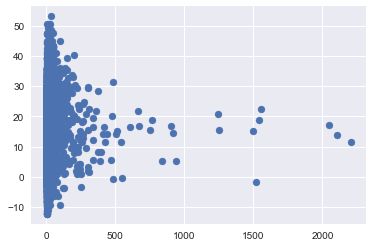

In [51]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

model = mosquitos
df = X
folds=10
scores = cross_val_score(model, df, y, cv=folds)
print "Cross-validated scores:", scores
# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=folds)
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print "Cross-Predicted Accuracy:", accuracy


In [63]:
import xgboost as xgb

# dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
# dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
# num_round = 2
# bst = xgb.train(param, dtrain, num_round)
# # make prediction
# preds = bst.predict(dtest)



ImportError: No module named xgboost

In [59]:
features = traps.columns.drop(['Species','Date','Trap','Spray','Spray_Days_Ago'])

traps_minmax = pd.DataFrame(MinMaxScaler().fit_transform(traps[features]),columns=features)

X = traps_minmax[features]
y = traps.WnvPresent

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.33, random_state=0)

RF = RandomForestClassifier(n_estimators = 5, bootstrap=True, max_depth=3,
                            max_features='auto',min_samples_leaf= 1, min_samples_split= 4)
RF_model= RF.fit(X_train,y_train)
score_model(RF_model)

1.0

### Random Forest Grid Search

In [14]:
grid_search_params = { 'max_features' : ['auto',None],
                    'max_depth':[None, 1, 5, 3],
                    'min_samples_split':[2,3,5],
                    'min_samples_leaf':[1,2,5],
                    'bootstrap':[True, False]
    
}

In [15]:
gs = GridSearchCV(RF, grid_search_params)

In [16]:
k = gs.fit(X_train,y_train)

In [17]:
k.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [18]:
k.score(X,y)

1.0

In [19]:
score_model(k)

1.0

## Support Vector Machine

Currently performing at .50 (bad)

In [85]:
from sklearn.svm import SVC

In [86]:
svmc= SVC(probability=True)

In [87]:
svm_model = svmc.fit(X_train,y_train)

In [88]:
grid_search_params = { 'C' : [1,2,3.01,.001],
                    'kernel':['rbf', 'linear','poly']
}

In [89]:
gsvm = GridSearchCV(svmc, grid_search_params)

In [90]:
svm = gsvm.fit(X_train,y_train)

In [91]:
svm.best_params_

{'C': 1, 'kernel': 'rbf'}

In [92]:
score_model(svm)

1.0

In [93]:
svm.score(X,y)

1.0

## ADA Boost

currently performs at .51

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
adaboost= AdaBoostClassifier()

In [ ]:
ada_model=adaboost.fit(X,y)

In [ ]:
adaboost.score(X,y)

# Import and Transform Test Data

In [4]:
test = pd.read_csv('assets/test.csv')
test.columns
# Because records are capped at 50 mosquitos,
# we are grouping the data to obtain a unique
# observation record per trap per date, with
# a total sum of NumMosquitos



test = test[['Trap','Latitude','Longitude','Date','Species']]

In [6]:
### converting datetime

test.Date = pd.to_datetime(test.Date)

# Create dummies for Species
dummies = pd.get_dummies(test, columns=['Species'])

# Create a new df with the dummies
traps_2_cols = test.columns.drop('Species')
test_2 = pd.concat([test[traps_2_cols],dummies])

# Weather data:
# the PrecipTotal column contains the letter 'T' in some rows
# this indicates a 'trace' amount of precipitation, which is
# defined as less than 0.005
# 'M' indicates missing data
# 'PrecipTotal','Tavg'

In [10]:
test_backup = test
test = test_2
## Applying weather data
test['Tmax'] = weather_add(test, weather_col='Tmax', func=np.mean)
test['Tmin'] = weather_add(test, weather_col='Tmin', func=np.mean)
test['rain'] = weather_add(test, weather_col='PrecipTotal', func= np.sum)
test['Tmax_3'] = weather_add(test, weather_col='Tmax', func=np.mean, days_range=3)
test['Tmax_20'] = weather_add(test, weather_col='Tmax',func=np.mean, days_range=20)

In [11]:
for col in ['Tavg','DewPoint','WetBulb','CodeSum','StnPressure','SeaLevel', 'ResultSpeed', 'ResultDir','AvgSpeed']:
    test[col] = weather_add(test, weather_col=col, func=np.mean)

## Spray data
# add_spray_data(test)

In [12]:
## Export the tranformed test data to a folder in the repo 
## so we don't have to run the above cells every time
## data is not scaled in this csv
## only the weather data has been added
## includes species dummies
test.to_csv('./assets/Test_transformed/test_transformed_jd.csv',sep=',', encoding='utf-8')

In [ ]:
# test = pd.read_csv('./assets/Test_transformed/test_transformed.csv')

In [ ]:
## create predictions for nummosquitos



In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features = traps.columns.drop(['Species','Date','Trap','Spray','Spray_Days_Ago','WnvPresent','NumMosquitos'])


traps_minmax = pd.DataFrame(MinMaxScaler().fit_transform(test[features]),columns=features)

X = traps_minmax[features]
y = RF_model.predict(X)
score_model(RF_model)

ValueError: Number of features of the model must match the input. Model n_features is 18 and input n_features is 16 

In [19]:
# test[features].head(2)

test.columns

test.drop(['Date','Species_CULEX ERRATICUS','Species_CULEX PIPIENS','Species_CULEX PIPIENS/RESTUANS','Species_CULEX RESTUANS','Species_CULEX SALINARIUS','Species_CULEX TARSALIS','Species_CULEX TERRITANS','Species_UNSPECIFIED CULEX'])


Index([u'Date', u'Latitude', u'Longitude', u'Species_CULEX ERRATICUS',
       u'Species_CULEX PIPIENS', u'Species_CULEX PIPIENS/RESTUANS',
       u'Species_CULEX RESTUANS', u'Species_CULEX SALINARIUS',
       u'Species_CULEX TARSALIS', u'Species_CULEX TERRITANS',
       u'Species_UNSPECIFIED CULEX', u'Trap', u'Tmax', u'Tmin', u'rain',
       u'Tmax_3', u'Tmax_20', u'Tavg', u'DewPoint', u'WetBulb', u'CodeSum',
       u'StnPressure', u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed'],
      dtype='object')

In [47]:
test_X = test[features]

# Exporting to test

In [ ]:
###This function will takes a model and a model name(as a string), generate predictions, 
### and save that as a CSV labeled with the model name and date.
import time 
import math
def model_and_export(model, model_name):
    predictions = model.predict(test)
    indexes=np.arange(1, len(predictions)+1, 1)
    preds_df = pd.DataFrame(data=[indexes, predictions]).T
    preds_df.columns =['Id','WnvPresent']
    location = './submissions/{}_{}.csv'.format(model_name, time.strftime("%d_%m_%Y"))
    preds_df.to_csv(location, index=False)
    return
    

In [ ]:
model_and_export(RF_model, 'RF_test_JD')

In [77]:
model_and_export(svm_model, 'SVM')

You can test the model by submitting the results CSV to :

https://www.kaggle.com/c/predict-west-nile-virus/submit

please note that only 5 submission can be made per day. 

Make note of the model and score below:




In [28]:
model_and_export(ada_model, 'ADABoost')

In [ ]:
model_and_export(RF_model, 'RF_test_JD')